# Synopsis

We now apply PCA to our corpus of novels, using the same reduced TFIDF matrix we used for HCA.

# Configuration

In [1]:
db_file = "/sfs/qumulo/qhome/sk5be/DS5559/HarryPotter.db"

# Libraries

In [2]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Pragmas

In [3]:
%matplotlib inline

# Process

## Import data

In [14]:
with sqlite3.connect(db_file) as db:
    bags = pd.read_sql("SELECT * FROM bag", db, index_col='bag_id')
    tfidf = pd.read_sql("SELECT * FROM tfidf_small", db, index_col=['bag_id','term_id'])    
    vocab = pd.read_sql("select * from vocab", db, index_col='term_id')
    doc = pd.read_sql("select * from doc",db)
    token = pd.read_sql("select * from token", db)

In [6]:
con = sqlite3.connect("/sfs/qumulo/qhome/sk5be/DS5559/HarryPotter.db")
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('docpair',), ('dtm_tfidf',), ('term_pair',), ('term_kde',), ('vocab',), ('token',), ('doc',), ('tfidf_small',), ('bag',)]


## Unpack TFIDF

In [17]:
TFIDF = tfidf.unstack()
TFIDF.columns = TFIDF.columns.droplevel(0)
vocab_idx = TFIDF.columns

## Run PCA

In [18]:
pca = PCA(n_components=10)
projected = pca.fit_transform(normalize(TFIDF.values, norm='l2'))

In [21]:
bags.head()

,book_num,chap_num
bag_id,,
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


## Plot results

In [31]:
def plot_pca(subspace, labels, pc_x = 0, pc_y = 1, figsize=(15, 10), annotate=False):
    plt.figure(figsize=figsize)
    plt.scatter(projected[:, pc_x], 
                projected[:, pc_y],
                c=labels, 
                edgecolor='none', 
                alpha=0.5,
                cmap=plt.cm.get_cmap('terrain', 10))
    plt.xlabel('PC{}'.format(pc_x))
    plt.ylabel('PC{}'.format(pc_y))
    if annotate:
        for i, x in enumerate(subspace):
            plt.annotate(bags.loc[i].book_num, (x[pc_x], x[pc_y])) # SHOULD BE AN FUNCTION ARG

In [33]:
# genres = bags.genre
# letters = genres.unique().tolist()
# genre_ids = genres.apply(lambda x: letters.index(x)).values

In [25]:
books = bags.book_num
books_letters = books.unique().tolist()
book_ids = books.apply(lambda x: books_letters.index(x)).values

[0, 1, 2, 3, 4, 5, 6]

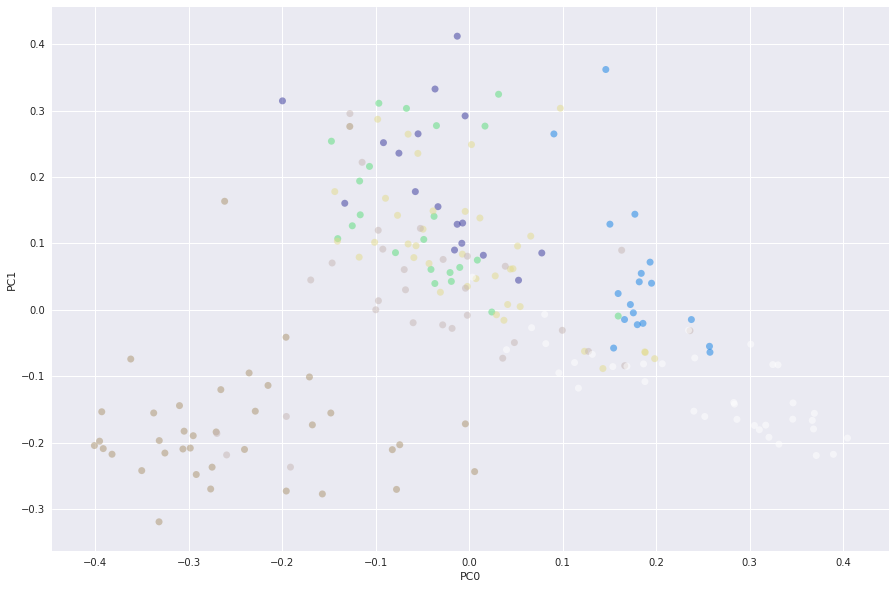

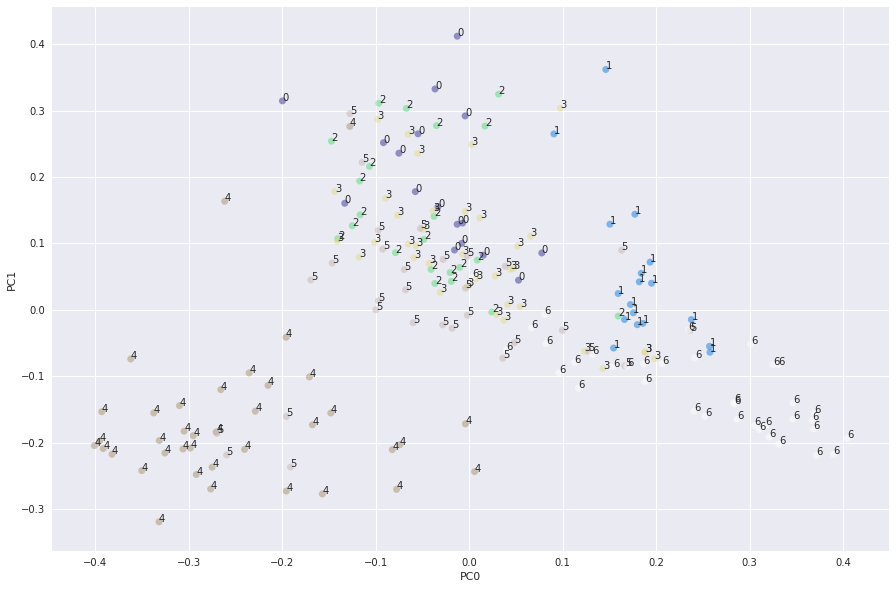

In [34]:
plot_pca(projected, book_ids, 0, 1)
plot_pca(projected, book_ids, 0, 1, annotate=True)

### PC1 vs PC2

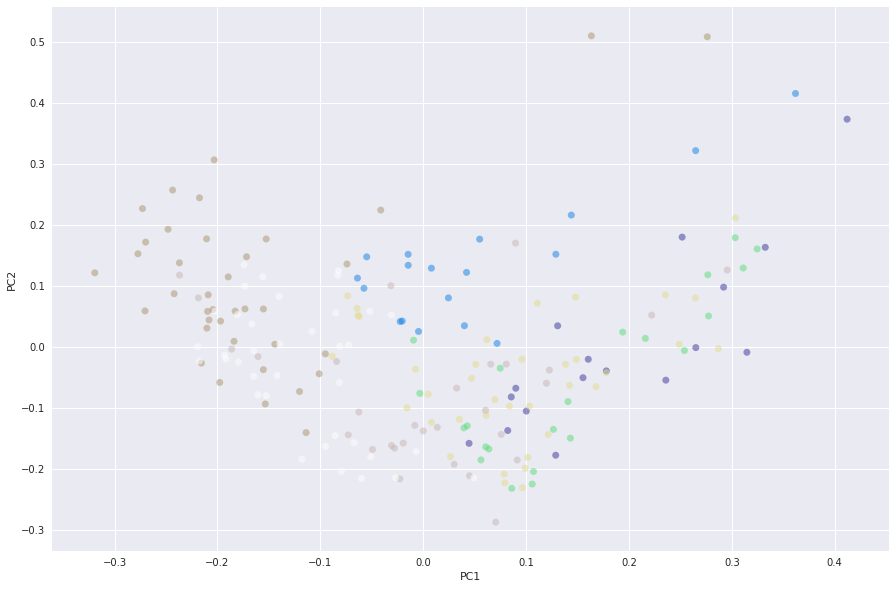

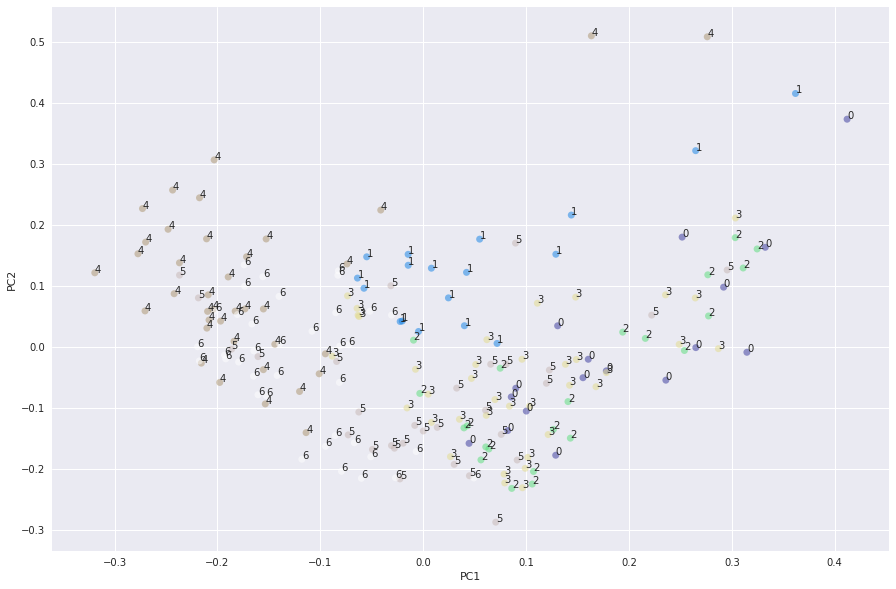

In [36]:
plot_pca(projected, book_ids, 1, 2)
plot_pca(projected, book_ids, 1, 2, annotate=True)

### PC2 vs PC3

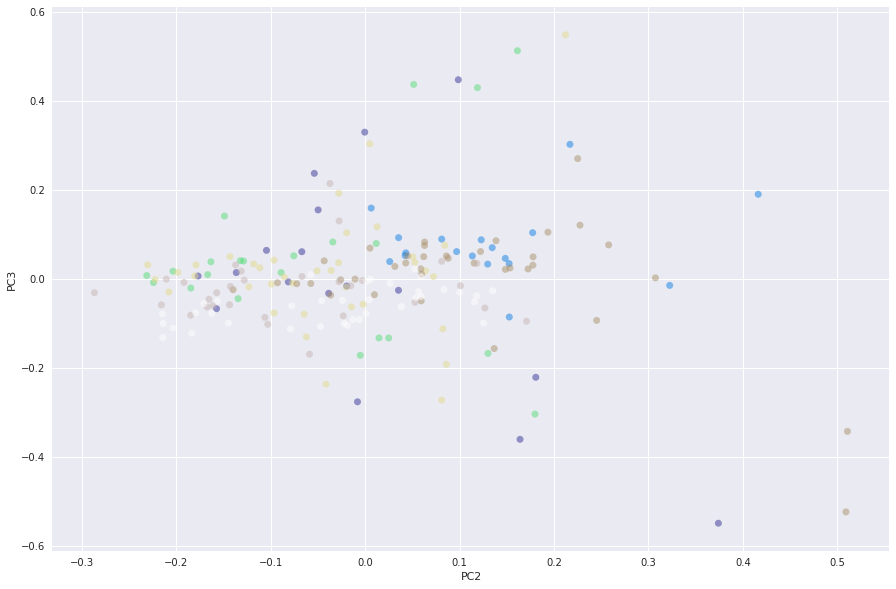

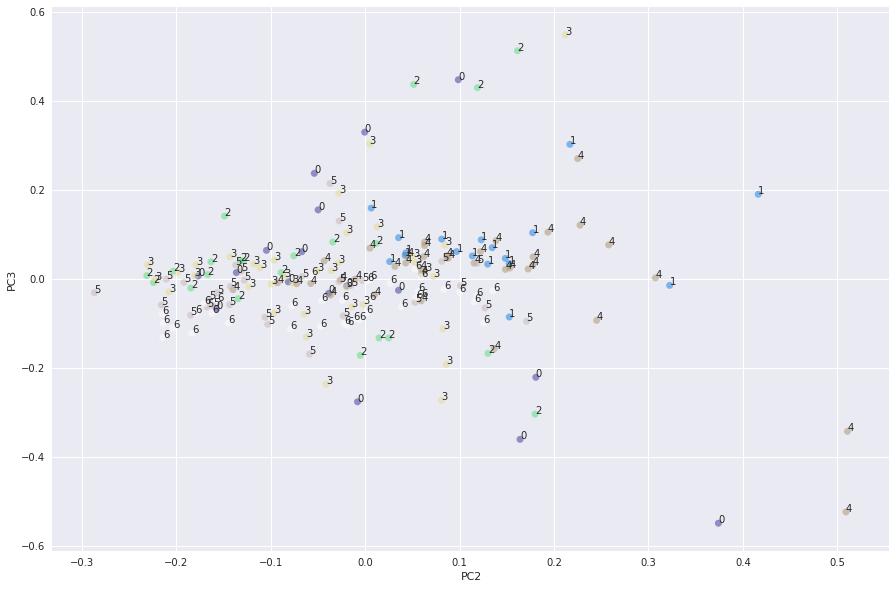

In [37]:
plot_pca(projected, book_ids, 2, 3)
plot_pca(projected, book_ids, 2, 3, annotate=True)

## View component loadings

We now explore the contribution of specific features (terms) to the components. Note that we could save the PCA values to our vocabulary table, or to a separate table with the restricted terms only.

In [38]:
COMPS = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_))
COMPS.columns = ["PC{}".format(i) for i in COMPS.columns]
COMPS.index = vocab_idx

In [39]:
vshort = vocab.loc[vocab_idx]

In [40]:
vshort = pd.concat([vshort, COMPS], axis=1)

In [41]:
vshort.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,...,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_id,,,,,,,,,,,,,,,,,,,,,
3,'a,52,0.000046,'a,0,30,0.015691,0.000079,0.002221,42.730055,...,-0.012214,-0.010195,0.004674,0.001258,0.001153,-0.002728,-0.001648,0.001710,-0.000824,0.001247
191,'come,51,0.000045,'come,0,27,0.014114,0.000071,0.001103,44.241955,...,-0.012082,-0.010589,0.005535,0.002322,0.002042,0.002415,0.001486,0.001832,-0.001856,-0.000813
218,'d,1380,0.001230,'d,0,157,0.494177,0.002483,0.012814,142.075725,...,-0.015780,0.016237,-0.014340,-0.001912,-0.005083,-0.001504,0.004671,0.000737,0.001181,-0.003439
249,'did,47,0.000042,'did,0,23,0.012027,0.000060,0.001632,44.044886,...,-0.014243,-0.010166,0.005921,-0.000323,-0.000136,-0.001007,-0.000159,0.001739,-0.002180,-0.000103
283,'dumbledore,57,0.000051,'dumbledor,0,29,0.016740,0.000084,0.001360,47.677939,...,-0.014786,-0.011771,0.003259,0.000593,-0.003183,-0.001061,-0.000910,0.002508,-0.000442,-0.002738


### PC0 loadings

We note that PC0 clearly distinguishes between Gothic and Detective fiction, but cannot distinguish betwen Poe and Austen, who reside in the middle of the spectrum.

In [43]:
vshort.sort_values('PC0', ascending=False)[['term_str','PC0']]

,term_str,PC0
term_id,,
7169,ebatescom,0.057597
18699,sister,0.015468
19287,soul,0.015372
21705,tunnel,0.014237
4263,child,0.014066
9604,grave,0.013059
17425,rock,0.011744
19428,spiders,0.011145
4968,connection,0.010748


### PC1 loadings

PC1 does distinguish between Poe and Austen.

In [44]:
vshort.sort_values('PC1', ascending=False)[['term_str','PC1']]

,term_str,PC1
term_id,,
20814,ter,0.072805
8278,field,0.039614
12950,match,0.024455
874,'s,0.024423
19653,stadium,0.016612
218,'d,0.016237
3781,cabin,0.014024
15535,points,0.013298
9432,goal,0.013286


### PC2 loadings

In [45]:
vshort.sort_values('PC2', ascending=False)[['term_str','PC2']]

,term_str,PC2
term_id,,
20814,ter,0.063357
21381,towards,0.031531
735,'oh,0.025294
4094,centaurs,0.020055
8278,field,0.017162
19653,stadium,0.015231
943,'so,0.012629
15358,pitch,0.012466
8834,forwards,0.011280


# Conclusion

| &nbsp; | PC0 | PC1 |
|----|---|-----|
| Gothic | + | 0 |
| Detective | - | 0 |
| Poe | 0 | - |
| Austen | 0 | + |
